In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from keras.datasets import mnist, fashion_mnist
import tensorflow.keras as kb
from tensorflow.keras import backend
import tensorflow as tf

2023-10-04 22:51:45.581551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Advanced CNN Techniques
- Data Augmentation
- Residual Connections
- Depthwise Separable Connections
- Visualizing Layer Activations
- Visualizing Filters
- Grad CAM


## Data Augmentation

Data Augmentation is a method specific to CNNs that allows us to regularize our Network by showing the network the same image over and over with *slight* changes to things like:

- rotation
- crop
- zoom
- translation

This is also helpful because we want our CNN to be able to recognize images even when they're shifted a little bit. 

Keras has a bunch of [`Random_*` layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/) which perform data augmentation for us. We can add a stack of them to a CNN before the first layer in order to perform data augmentation. 

In [2]:
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = kb.utils.to_categorical(y_train, 10)
y_test = kb.utils.to_categorical(y_test, 10)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
model = kb.Sequential([
    kb.layers.InputLayer(input_shape =(28,28,1)),
    kb.layers.RandomFlip(),
    kb.layers.RandomZoom(0.2),
    kb.layers.RandomRotation(0.1),
    kb.layers.Conv2D(32, (3, 3), activation='relu', padding = "same"),
    kb.layers.Conv2D(64, (3, 3), activation='relu', padding = "same"),
    kb.layers.MaxPooling2D((2, 2)),
    kb.layers.Flatten(),
    kb.layers.Dense(100, activation='relu'),
    kb.layers.Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 28, 28, 1)         0         
                                                                 
 random_zoom (RandomZoom)    (None, 28, 28, 1)         0         
                                                                 
 random_rotation (RandomRot  (None, 28, 28, 1)         0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                     

In [4]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, epochs=5, validation_data = (x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 127s 67ms/step - loss: 0.7319 - accuracy: 0.7250 - val_loss: 0.5496 - val_accuracy: 0.7964
Epoch 2/5
1875/1875 [==============================] - 109s 58ms/step - loss: 0.5397 - accuracy: 0.7992 - val_loss: 0.4894 - val_accuracy: 0.8257
Epoch 3/5
1875/1875 [==============================] - 101s 54ms/step - loss: 0.4826 - accuracy: 0.8209 - val_loss: 0.4590 - val_accuracy: 0.8356
Epoch 4/5
1875/1875 [==============================] - 96s 51ms/step - loss: 0.4474 - accuracy: 0.8352 - val_loss: 0.4609 - val_accuracy: 0.8317
Epoch 5/5
1875/1875 [==============================] - 96s 51ms/step - loss: 0.4241 - accuracy: 0.8429 - val_loss: 0.4492 - val_accuracy: 0.8362


## Residual Connections

Residual Connections create two paths for data to flow through:

1. the traditional path which pushes the input image through the convolutional + pooling layers
2. a non-destructive path that passes the image through unchanged (though we may reduce the size to match the output of the other path)

These two paths are then added together before passing the output through to the next block of conv + pool layers. 

Because we're no longer using a simple, sequential stack of layers, we have to use the Functional API to define this architechture rather than `Sequential()`. 😭

In [5]:
input = kb.Input(shape = (28,28,1))
x = kb.layers.Conv2D(32, (3,3), activation = "relu")(input)
residual = x
x = kb.layers.Conv2D(64, (3,3), padding = "same", activation = "relu")(x)
residual = kb.layers.Conv2D(64,(1,1))(residual)
x = kb.layers.add([x,residual])
x = kb.layers.MaxPooling2D((2, 2))(x)
x = kb.layers.Flatten()(x)
x = kb.layers.Dense(100, activation='relu')(x)
output = kb.layers.Dense(10, activation='softmax')(x)

model = kb.Model(inputs = input, outputs = output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 26, 26, 32)           320       ['input_2[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 26, 26, 64)           18496     ['conv2d_2[0][0]']            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 26, 26, 64)           2112      ['conv2d_2[0][0]']            
                                                                                              

In [6]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, epochs=5, validation_data = (x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 89s 47ms/step - loss: 0.3506 - accuracy: 0.8751 - val_loss: 0.2650 - val_accuracy: 0.9007
Epoch 2/5
1875/1875 [==============================] - 88s 47ms/step - loss: 0.2191 - accuracy: 0.9192 - val_loss: 0.2417 - val_accuracy: 0.9119
Epoch 3/5
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1653 - accuracy: 0.9377 - val_loss: 0.2498 - val_accuracy: 0.9122
Epoch 4/5
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1226 - accuracy: 0.9546 - val_loss: 0.2349 - val_accuracy: 0.9209
Epoch 5/5
1875/1875 [==============================] - 85s 45ms/step - loss: 0.0891 - accuracy: 0.9673 - val_loss: 0.2852 - val_accuracy: 0.9195


## Depthwise Separable Convolutions

[Depthwise Separable Convolutions](https://keras.io/api/layers/convolution_layers/separable_convolution2d/) are a way to reduce the computational cost of performing a convolution. DSC's apply a filter to each channel in an input image *separately* and then convolve those outputs together. This does assume that the different channels in the input are highly independent, but that's often true so it typically won't reduce the performance of your model unless that assumption is violated.

Luckily, `SeparableConv2D()` is a drop-in replacement for `Conv2D()`.

In [7]:
model = kb.Sequential([
    kb.layers.InputLayer(input_shape =(28,28,1)),
    kb.layers.SeparableConv2D(32, (3, 3), activation='relu', padding = "same"),
    kb.layers.SeparableConv2D(64, (3, 3), activation='relu', padding = "same"),
    kb.layers.MaxPooling2D((2, 2)),
    kb.layers.Flatten(),
    kb.layers.Dense(100, activation='relu'),
    kb.layers.Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separabl  (None, 28, 28, 32)        73        
 eConv2D)                                                        
                                                                 
 separable_conv2d_1 (Separa  (None, 28, 28, 64)        2400      
 bleConv2D)                                                      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_4 (Dense)             (None, 100)               1254500   
                                                      

In [8]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, epochs=1, validation_data = (x_test, y_test))

1875/1875 [==============================] - 49s 26ms/step - loss: 0.4173 - accuracy: 0.8529 - val_loss: 0.3311 - val_accuracy: 0.8802


## Visualizations

### Visualizing Layer Activations

In [9]:
model = kb.Sequential([
    kb.layers.InputLayer(input_shape =(28,28,1)),
    kb.layers.Conv2D(32, (3, 3), activation='relu', padding = "same", name = "c1"),
    kb.layers.Conv2D(64, (3, 3), activation='relu', padding = "same", name = "c2"),
    kb.layers.MaxPooling2D((2, 2)),
    kb.layers.Flatten(),
    kb.layers.Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c1 (Conv2D)                 (None, 28, 28, 32)        320       
                                                                 
 c2 (Conv2D)                 (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 12544)             0         
                                                                 
 dense_6 (Dense)             (None, 10)                125450    
                                                                 
Total params: 144266 (563.54 KB)
Trainable params: 144266 (563.54 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [10]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, epochs=10, validation_data = (x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 83s 44ms/step - loss: 0.3745 - accuracy: 0.8675 - val_loss: 0.2947 - val_accuracy: 0.8893
Epoch 2/10
1875/1875 [==============================] - 80s 43ms/step - loss: 0.2468 - accuracy: 0.9124 - val_loss: 0.2555 - val_accuracy: 0.9083
Epoch 3/10
1875/1875 [==============================] - 80s 42ms/step - loss: 0.2022 - accuracy: 0.9271 - val_loss: 0.2387 - val_accuracy: 0.9178
Epoch 4/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.1704 - accuracy: 0.9390 - val_loss: 0.2556 - val_accuracy: 0.9105
Epoch 5/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.1433 - accuracy: 0.9493 - val_loss: 0.2441 - val_accuracy: 0.9169
Epoch 6/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.1213 - accuracy: 0.9563 - val_loss: 0.2486 - val_accuracy: 0.9189
Epoch 7/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.1034 - accuracy: 0.9622 - val_loss: 0.2828 -

In [11]:
layer_out = []
layer_name = []

for layer in model.layers:
    if isinstance(layer, (kb.layers.Conv2D, kb.layers.MaxPooling2D)):
        layer_out.append(layer.output)
        layer_name.append(layer.name)

layer_activations = kb.Model(inputs = model.input, outputs = layer_out)

layer_activations.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 c1 (Conv2D)                 (None, 28, 28, 32)        320       
                                                                 
 c2 (Conv2D)                 (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
Total params: 18816 (73.50 KB)
Trainable params: 18816 (73.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
img = kb.utils.img_to_array(x_train[0])
img = np.expand_dims(img, axis = 0)
activations = layer_activations.predict(img)


1/1 [==============================] - 0s 157ms/step


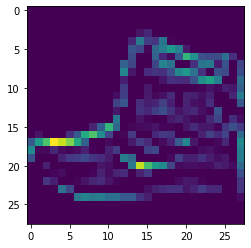

In [13]:
import matplotlib.pyplot as plt

# which layer and channel you want to look at
layer = 0
channel = 3

# grab layer and channel and plot
layer_act = activations[layer]
plt.imshow(layer_act[0,:,:,channel], cmap = "viridis")

### Visualizing Filters

We can also visualize the filters learned by your CNN by using *gradient **ascent*** to find an image that *maximally* activates the filter as it's slid across an input. 

We start with a blank image and then make iterative changes that maximize the filter output more and more at each step. 

In [14]:
layer = model.get_layer("c1")

feature_extractor = kb.Model(inputs = model.input, outputs = layer.output)

In [15]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, 28, 28, 1))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[2:-2, 2:-2, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return(image)

In [16]:
from IPython.display import Image, display

loss, img = visualize_filter(7)
kb.preprocessing.image.save_img("0.png", img)
display(Image("0.png"))

### Visualizing Class Activation Heatmaps


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


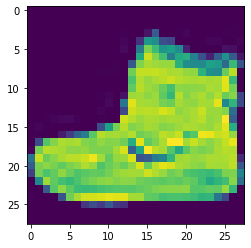

In [21]:
# model_builder = keras.applications.xception.Xception
# img_size = (299, 299)
# preprocess_input = keras.applications.xception.preprocess_input
# decode_predictions = keras.applications.xception.decode_predictions

img_size = (28, 28)
last_conv_layer_name = "max_pooling2d_3"

img = np.expand_dims(x_train[0], 0)
img.shape

plt.imshow(img.reshape((28,28)))


In [22]:

def get_img_array(img, size):
    # `array` is a float32 Numpy array of shape (28, 28, 1)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 [==============================] - 0s 40ms/step


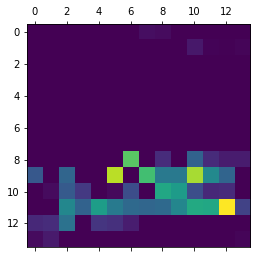

In [23]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

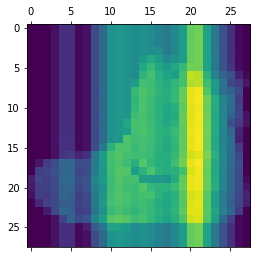

In [24]:

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :1]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    plt.matshow(superimposed_img.reshape((28,28)))
    plt.show()


save_and_display_gradcam(img, heatmap, alpha = 0.1)

## Occlusion

I built this [Shiny App](https://cmparlett.shinyapps.io/convolutionalneuralnetocclusion/) for you to play around with. You can upload any image, and occlude (or cover up) part of it and see how that changes the classification of the image. My favorite example is that if you cover up a corgi butt, the model is less confident that the image is of a Corgi!

<img src="https://drive.google.com/uc?export=view&id=1WPbTlOHlHY8T1XLQJUMHaQLsdwpm0dUE" alt="Q" width = “400”/>
